In [1]:
%load_ext autoreload
%autoreload 2
from storytelling import *

In [2]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

In [4]:
yesemite = "..//dat/4884.csv.gz"
df = pd.read_csv(yesemite)
df.shape

(250963, 12)

In [5]:
df = df[df["rt_id"].isna()]
print(df.shape)
df.head(2)

(148415, 12)


,id,text,created_at,retweet_count,user_id,user_followers_count,rt_id,rt_text,rt_created_at,rt_retweet_count,rt_user_id,rt_user_followers_count
1,476883051809886209,“@Troll__Football: Klose is just one goal behi...,Thu Jun 12 00:25:54 +0000 2014,1,2257448398,899,NaN,NaN,NaN,NaN,NaN,NaN
4,476883065797500928,Can't wait til World Cup starts👌⚽️,Thu Jun 12 00:25:57 +0000 2014,2,846252955,200,NaN,NaN,NaN,NaN,NaN,NaN


(array([ 1552.,  8572., 45280., 57201., 22893.,  7309.,  3028.,  1523.,
          543.,   127.]),
 array([0.30103   , 1.06099233, 1.82095467, 2.58091701, 3.34087935,
        4.10084169, 4.86080403, 5.62076636, 6.3807287 , 7.14069104,
        7.90065338]),
 <a list of 10 Patch objects>)

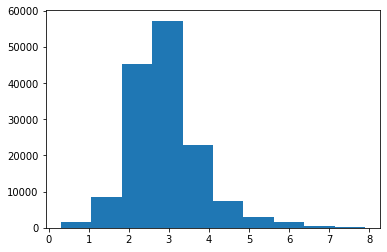

In [6]:
#df[df["user_followers_count"].hist()
df = df[df["user_followers_count"]>1]
follower = np.log10(df["user_followers_count"].values)
plt.hist(follower)

In [8]:
df1 = df[df["user_followers_count"]>10**6]
df1 = df1.reset_index()
df1.shape

(1289, 13)

In [9]:
DC = TwitterCleaner()
urlsearch = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
ALL_Sentences = []
Clean_sentences = []
for i,row in df1.iterrows():
    #Data.append(DC.Clean(df1.loc[i, "text"]))
    sentence = df1.loc[i, "text"].strip("\n")
    sentence = re.sub(r'RT\s@[\w]*', '', sentence)
    sentence = re.sub(r'MT\s@[\w]*', '', sentence)
    sentence = re.sub(r'@[\w]*', '', sentence)
    sentence = re.sub(r'#[\w]*', '', sentence)
    sentence = re.sub(r'&amp;', 'and', sentence)
    sentence = re.sub(urlsearch, '', sentence)
    #sentence = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = sentence.strip()
    sentences = re.split('; |, ',sentence)
    new_sentences = []
    for s in sentences:
        if "..." in s:
            continue
        new_sentences.append(s)
    sentence = "".join(new_sentences)
    if sentence == "":
        continue
    ALL_Sentences.append(sentence)
    Clean_sentences.append(" ".join(DC.Clean(sentence)))

In [10]:
sentence_vectors = Sentence2WE(Clean_sentences, word_embeddings)
sim_mat = TextRankScoreMat(sentence_vectors)

In [21]:
threashold = 0.8
rm_idx = []
kept_idx = []
for i in range(sim_mat.shape[0]):
    if i in rm_idx:
        continue
    kept_idx.append(i)
    for j in range(sim_mat.shape[1]):
        if sim_mat[i,j]>threashold:
            rm_idx.append(j)   
print(len(kept_idx))

88


In [22]:
art = []
selected_Clean = []
for i in kept_idx:
    art.append(ALL_Sentences[i])
    selected_Clean.append(Clean_sentences[i])
    #print(i, ALL_Sentences[i])
out = open("worldcup.psodu.txt", 'wt')
out.write(" ".join(art))

6591

In [23]:
sentence_vectors = Sentence2WE(selected_Clean, word_embeddings)
sim_mat = TextRankScoreMat(sentence_vectors)

In [24]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [25]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(art)), reverse=True)
rank_art = []
for i in range(10):
    print(ranked_sentences[i][1])

Tomorrowcompetition begins between the world's fiercest football teams. Who will take home the cup?
World cup todayLet's go babyyyyy
: Here's everything you need to know about every single World Cup team
Happy World Cup! 
Let's get it started with a W for BRA 

 to Vogue Brazil
Ahead on : All eyes on Brazil as the 2014 World Cup kicks off.
Bosnia's and Mexico's  players were told to not have sex in Brazil. Do bedroom gymnastics affect the game?
The final chapter of our series takes us to South Africa and FC Barcelona's finest hour at the World Cup
Today's  on the move (in a car) is a World Cup special. Watch it here
Police fire tear gas at protesters in Sao Paulo ahead of today's opening World Cup match.
As Bryant ends his playing dayshe wants to take that passion into the business world:


In [26]:
rank_arts = []
for score, text in ranked_sentences:
    #print(s,j)
    rank_arts.append(text)

In [27]:
out = open("worldcup.psodu.txt", 'wt')
out.write(" ".join(rank_arts))

6591

In [87]:
Data = []
for i,row in df1.iterrows():
    Data.append(DC.Clean(df1.loc[i, "text"]))
DC.corpusWC(Data, "4884.1gram.wc.txt")

In [88]:
vocabularies = pd.read_csv("4884.1gram.wc.txt", names=["Word", "Count"], delimiter="\t")["Word"].values[:400]
#vocabularies
BW = DC.BagOfWords(Data, vocabularies)
print(BW.shape)

(4463, 400)


(4463, 80)


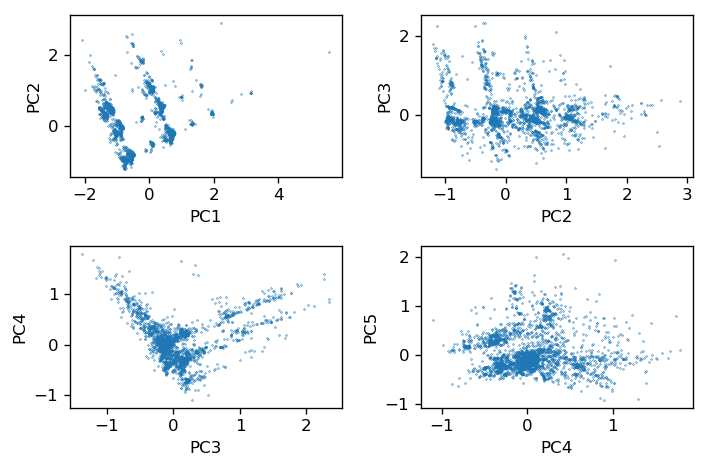

In [89]:
pca = PCA(n_components=80, svd_solver='arpack')
X = pca.fit_transform(BW)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()

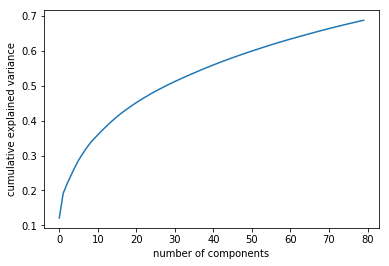

In [90]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [91]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :80])

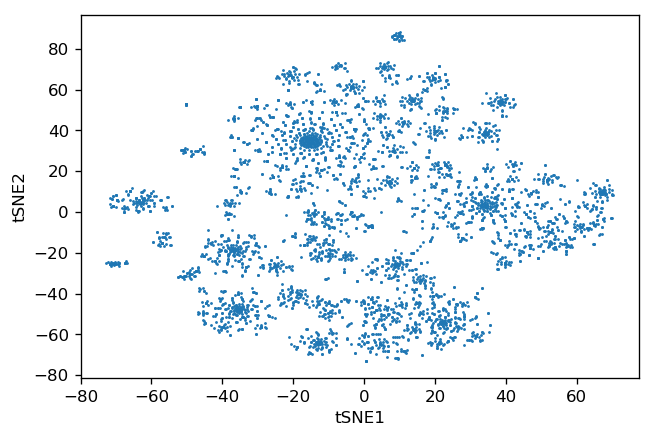

In [92]:
fig = plt.figure(dpi=120)
ax = plt.subplot(111)
ax.scatter(Y[:,0], Y[:,1],s=0.5)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.show()

In [97]:
Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=40)
clusters = Agg.fit_predict(Y)
groups = AssignCluster(Y, clusters)

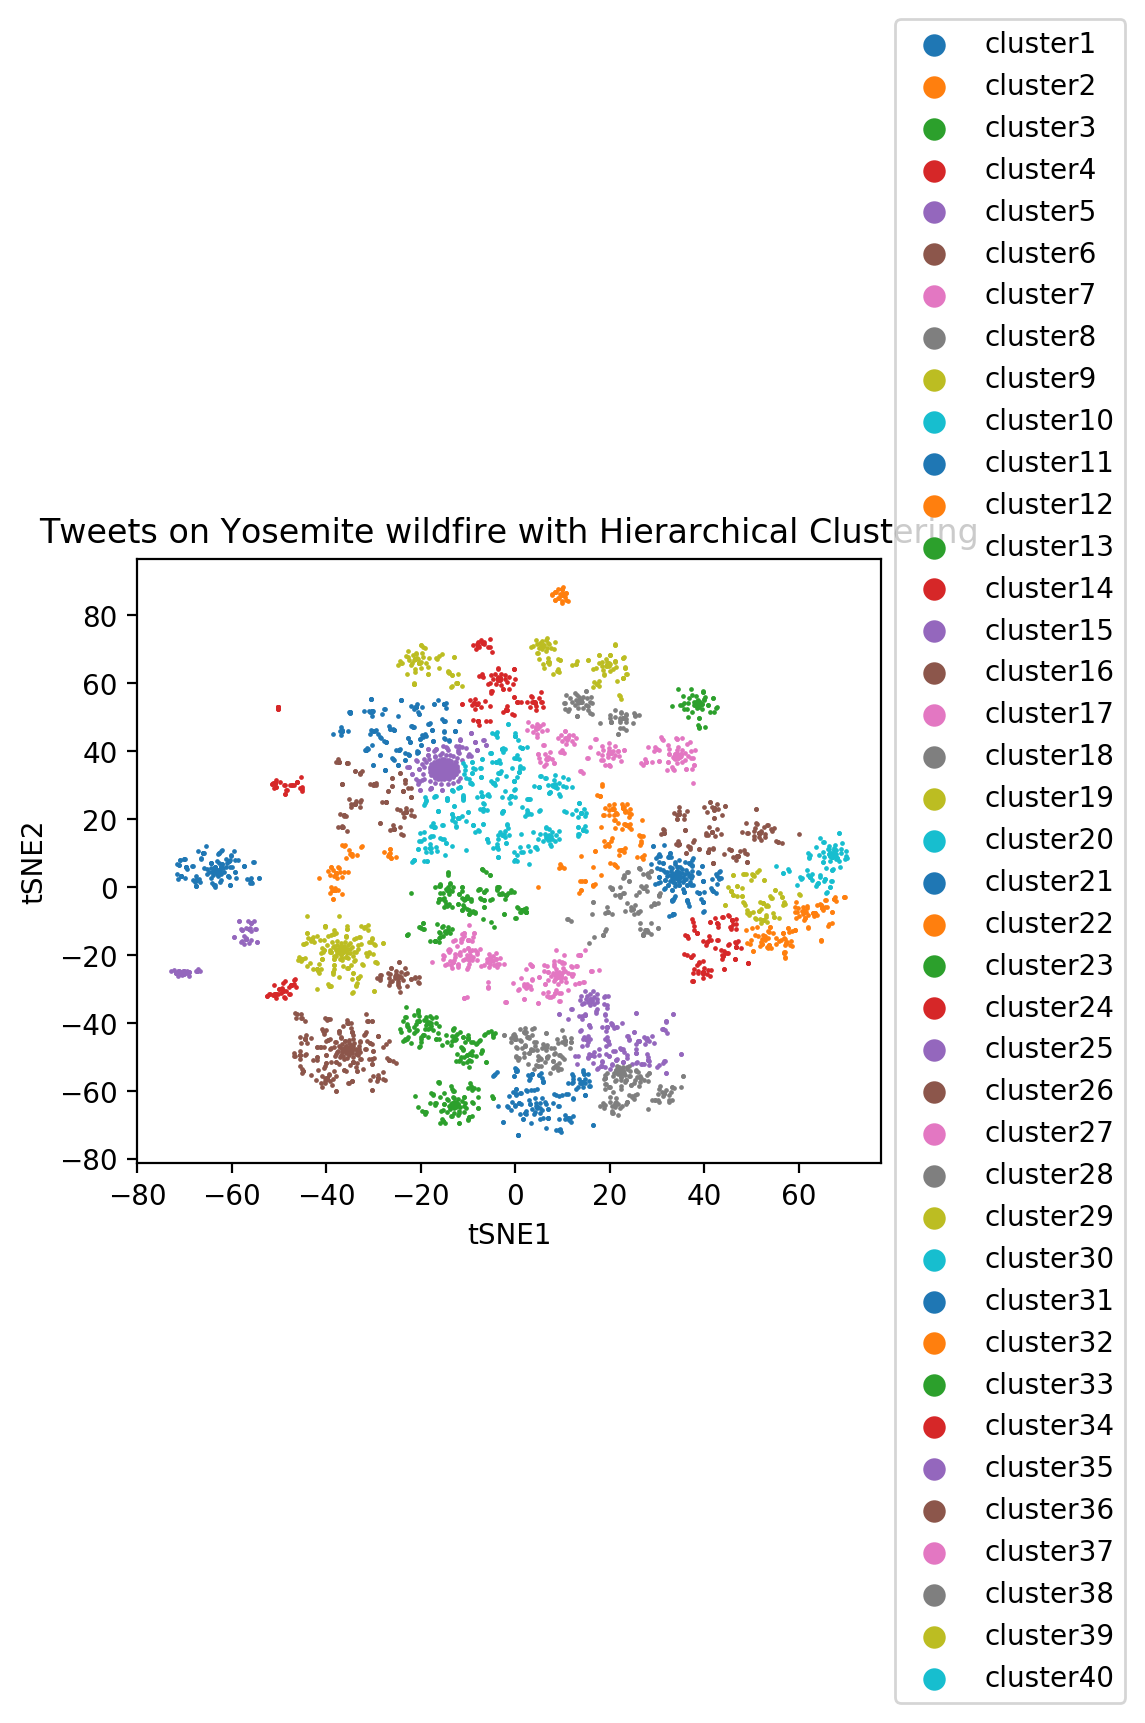

In [98]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [100]:
for i in range(max(clusters)+1):
    print(i+1)
    topics = np.where(clusters==i)
    #print(topics)
    topics = topics[0]
    DC.showTopic(df1, topics, Nshow=3)
    print("-------------")

1
14
@jasongacek Yes I'm excited for the World Cup. Go USA! Thu Jun 12 00:31:44 +0000 2014
jasongacek yes excited world cup go usa

141
.@nickfirchau puts Arena Corinthians, the stadium for the World Cup opener, to the test: http://t.co/kwOF3YUXwE Thu Jun 12 04:31:22 +0000 2014
nickfirchau puts arena corinthians stadium world cup opener test

184
World Cup support is up at the Gav! @michelrouxjr http://t.co/O9On3JhVIb Thu Jun 12 06:16:17 +0000 2014
world cup support gav michelrouxjr

207
World Cup Day 1 Prediction:
#BRA 2-0 #CRO (Fred &amp; Neymar) Thu Jun 12 07:13:55 +0000 2014
world cup day prediction bra cro fred amp neymar

-------------
2
11
This super beagle is so psyched for the World Cup http://t.co/9oHCkV4KCf Thu Jun 12 00:30:54 +0000 2014
super beagle psyched world cup

92
Wait, Jesus Supports Italy In The World Cup?  http://t.co/A6zWYNlx5r http://t.co/KP9TaSPE9F Thu Jun 12 03:00:13 +0000 2014
wait jesus supports italy world cup

149
Remembering South Africa’s World Cup, four